In [1]:
%load_ext autoreload
%autoreload 2

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, resample

from brioche.beamformer import DS, MVDR, LCMV

/home/ddicarlo/Documents/Code/InProgress/2019@Barilan_dataset_dechorate/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [33]:
curr_dir = '../recipes/echo_aware_processing/'
data_filename = curr_dir + 'data_notebook.pkl'

# 1. Get the data: RIRs and Annotation

Surf the dEchorate and load the RIRs and the correspondent annotation

In [4]:
dataset_dir = '../data/dECHORATE/'
path_to_processed = '../data/processed/'
path_to_note_csv = dataset_dir + 'annotations/dECHORATE_database.csv'
path_to_after_calibration = path_to_processed + \
    'post2_calibration/calib_output_mics_srcs_pos.pkl'

# Some constant of the dataset
L = constants['rir_length']
Fs = constants['Fs']
c = constants['speed_of_sound']
L = constants['rir_length']
datasets_name = constants['datasets'][:6]
D = len(datasets_name)

# Annotation, RIRs from measurements, 'equivalent' synthetic RIRs
note_dict = load_from_pickle(path_to_after_calibration)
rdset = DechorateDataset(path_to_processed, path_to_note_csv)
sdset = SyntheticDataset()


In [5]:
# which microphones?
mics_idxs = [15, 16, 17, 18, 19]
I = len(mics_idxs)
# which mic is the reference?
ref_mic = 3 # the third

# which source?
srcs_idxs = [0, 1]
J = len(srcs_idxs)
# which src is the one to enhance?
tgt_src = 0 # the first

# how many echoes to rake?
K = 7
# in which order?
order = 'order' # earliest, strongest, order

In [20]:
rirs_real = np.zeros([L, I, J, D])
rirs_synt = np.zeros([L, I, J, D])
mics = np.zeros([3, I])
srcs = np.zeros([3, J])
toas = np.zeros([K, I, J])
toas_synt = np.zeros_like(toas)
toas_peak = np.zeros_like(toas)

for d, dset in enumerate(datasets_name):
    for i, m in enumerate(mics_idxs):
        for j, s in enumerate(srcs_idxs):

            # get rir from the recondings
            rdset.set_dataset(dset)
            rdset.set_entry(m, s)
            mic, src = rdset.get_mic_and_src_pos()
            _, rrir = rdset.get_rir()

            # measure after calibration
            mics[:, i] = note_dict['mics'][:, m]
            srcs[:, j] = note_dict['srcs'][:, s]

            # get synthetic rir
            sdset = SyntheticDataset()
            sdset.set_room_size(constants['room_size'])
            sdset.set_dataset(dset, absb=0.85, refl=0.15)
            sdset.set_c(c)
            sdset.set_k_order(17)
            sdset.set_mic(mics[0, i], mics[1, i], mics[2, i])
            sdset.set_src(srcs[0, j], srcs[1, j], srcs[2, j])
            # amp, tau, wall, order, gen = sdset.get_note()

            _, srir = sdset.get_rir(normalize=False)
            Ls = len(srir)

            # measure after calibration
            rirs_real[:, i, j, d] = rrir[:L]
            rirs_synt[:Ls, i, j, d] = srir[:Ls]

            toas_synt[:K, i, j] = note_dict['toa_sym'][:K, m, s]
            toas_peak[:K, i, j] = note_dict['toa_pck'][:K, m, s]

print('done with the extraction')
rirs_real = np.squeeze(rirs_real)
rirs_synt = np.squeeze(rirs_synt)

data = {
    'rirs_real' : rirs_real,
    'rirs_synt' : rirs_synt,
    'mics' : mics,
    'srcs' : srcs,
    'toas' : toas,
    'toas_synt' : toas_synt,
    'toas_peak' : toas_peak,
}


save_to_pickle(data_filename, data)
print('Saved.')

done with the extraction
Saved.


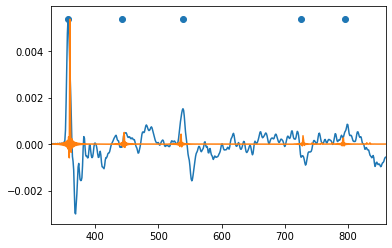

In [31]:
# Plot on sample

i, j, d = (0, 0, 0)

a = np.max(np.abs(rirs_real[:, i, j, d]))
t1  = np.argmax(rirs_synt[:, i, j, d])
plt.plot(rirs_real[:, i, j, d])
plt.plot(a * normalize(rirs_synt[:, i, j, d]))
plt.scatter(toas_peak[:, i, j]*Fs, a*np.ones_like(toas_peak[:, i, j]))
plt.xlim(t1 - 30, t1+500)
plt.show()

# 2. Load the Real Data
load samples from the WSJ dataset and convolve in with the rirs

In [39]:
data_dir = curr_dir + 'TIMIT_long_nili/'
s1m = data_dir + 'DR5_MHMG0_SX195_SX285_SX375_7s.wav'
s2m = data_dir + 'DR7_MGAR0_SX312_SX402_7s.wav'
s1f = data_dir + 'DR1_FTBR0_SX201_SI921_7s.wav'
s2f = data_dir + 'DR4_FKLC0_SI985_SI2245_7s.wav'

files = [s1m, s2m, s1f, s2f]
N = len(files)

In [76]:
wavs = []
for file in files:
    wav, fs = sf.read(file)
    assert len(wav.shape) == 1
    wavs.append(wav[:7*fs])
print('done.')
print('Fs wavs is', fs)

done.
Fs wavs is 16000


# 3. Make Audio Scene

In [139]:
d = 0 # first dataset
h_ = rirs_real[:, :, :, d] # real rirs
r = 0 # reference mic
inr = 30
snr = 50

In [56]:
mic_pos = mics
mic_pos

array([[3.35956993, 3.3818327 , 3.40966117, 3.44583818, 3.50149512],
       [2.40748639, 2.44071843, 2.48225849, 2.53626056, 2.61934068],
       [1.38561103, 1.38561103, 1.38561103, 1.38561103, 1.38561103]])

In [57]:
arr_pos = np.mean(mics, 1)
arr_pos

array([3.41967942, 2.49721291, 1.38561103])

In [48]:
tgt_pos = srcs[:, 0:1]
tgt_pos

array([[1.89407487],
       [4.52190448],
       [1.4481839 ]])

In [50]:
itf_pos = srcs[:, 1:2]
itf_pos

array([[1.6330509 ],
       [0.8420041 ],
       [1.02493109]])

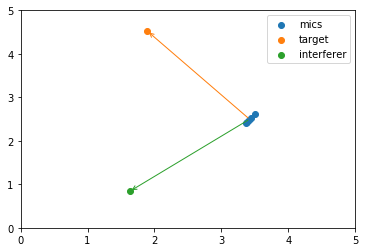

In [82]:
plt.scatter(mic_pos[0,:], mic_pos[1,:], label='mics')
plt.scatter(tgt_pos[0,:], tgt_pos[1,:], label='target')
plt.scatter(itf_pos[0,:], itf_pos[1,:], label='interferer')
plt.annotate('',
             (arr_pos[0], arr_pos[1]), 
             (tgt_pos[0], tgt_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C1'})
plt.annotate('', 
             (arr_pos[0], arr_pos[1]), 
             (itf_pos[0], itf_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C2'})
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.legend()
plt.show()

# 4. Make Mixtures

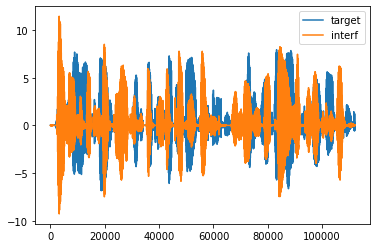

In [145]:
s1 = wavs[0]
s2 = wavs[1]

# center and scale for unit variance
ss1 = (s1-np.mean(s1))/np.std(s1)
ss2 = (s2-np.mean(s2))/np.std(s2)
assert len(ss1) == len(ss2)

plt.plot(ss1, label='target')
plt.plot(ss2, label='interf')
plt.legend()
plt.show()

In [147]:
# Upsampling and stacking
print(fs, '-->', Fs)
s_ = np.concatenate([resample(ss1, fs, Fs)[:, None], 
                     resample(ss2, fs, Fs)[:, None]], axis=1)
print(s_.shape)

Lc = 10*fs
c_ = np.zeros([Lc, I, J])

# Convolution, downsampling and stacking
print(fs, '-->', Fs)
for i in range(I):
    for j in range(J):
        cs = np.convolve(h_[:, i, j], s_[:, j], 'full')
        cs = resample(cs, Fs, fs)
        L = len(cs)
        print(i, j, L)
        c_[:L, i, j] = cs
        
print('Done.')

16000 --> 48000
(336000, 2)
16000 --> 48000
0 0 118519
0 1 118519
1 0 118519
1 1 118519
2 0 118519
2 1 118519
3 0 118519
3 1 118519
4 0 118519
4 1 118519
Done.


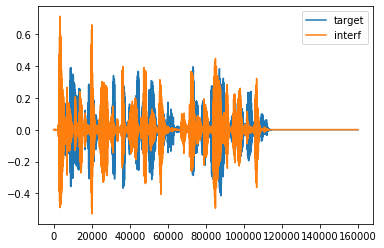

In [148]:
plt.plot(c_[:, r, 0], label='target')
plt.plot(c_[:, r, 1], label='interf')
plt.legend()
plt.show()

In [149]:
# Standardization wtr reference microphone
sigma_target = np.std(c_[:, r, 0])
sigma_interf = np.std(c_[:, r, 1])

c_[:, :, 0] = c_[:, :, 0] / sigma_target
c_[:, :, 1] = c_[:, :, 1] / sigma_interf

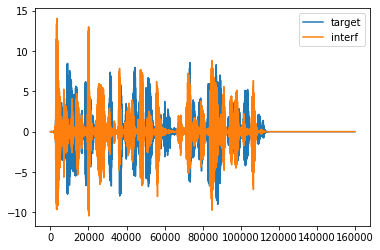

In [150]:
plt.plot(c_[:, r, 0], label='target')
plt.plot(c_[:, r, 1], label='interf')
plt.legend()
plt.show()

In [164]:
cs1 = np.concatenate([np.zeros([2*fs, I]), c_[:, :, 0], np.zeros([4*fs, I]), np.zeros([2*fs, I])], axis=0)
cs2 = np.concatenate([np.zeros([2*fs, I]), np.zeros([4*fs, I]), c_[:, :, 1], np.zeros([2*fs, I])], axis=0)
# measurement noise
ms = 

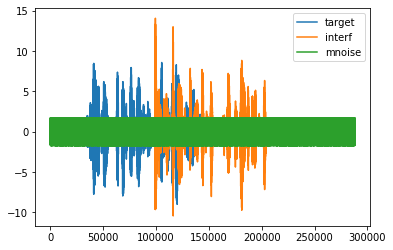

In [166]:
plt.plot(cs1[:, r], label='target')
plt.plot(cs2[:, r], label='interf')
plt.plot(ms[:, r], label='mnoise')
plt.legend(loc='upper right')
plt.show()